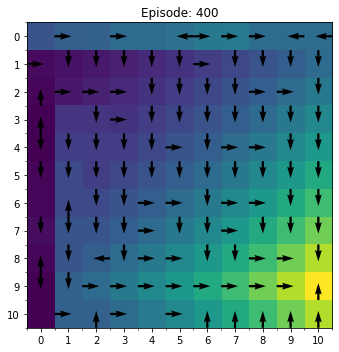

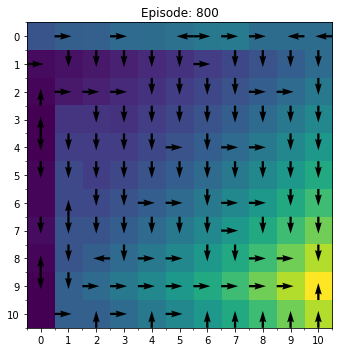

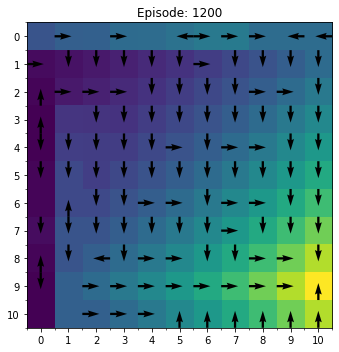

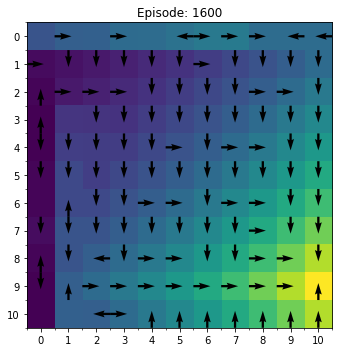

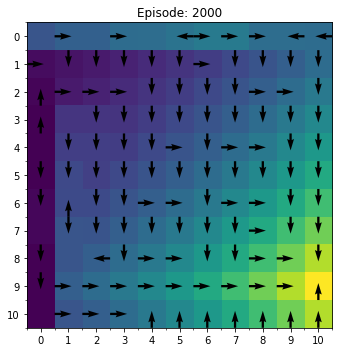

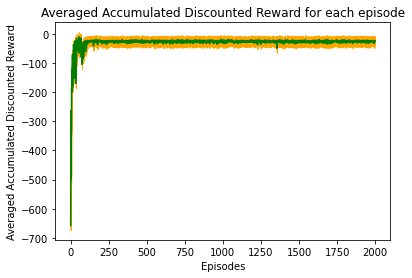

0
1
2
3
4


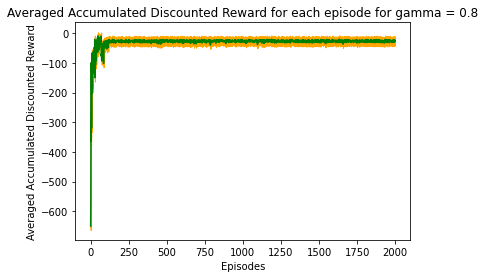

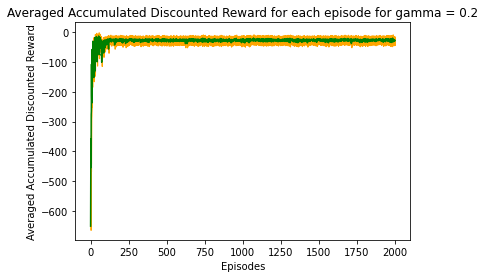

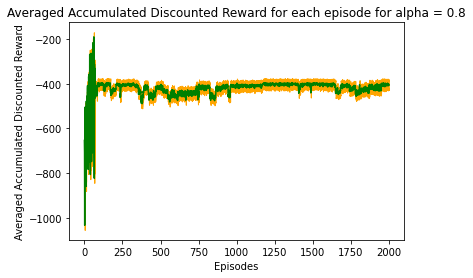

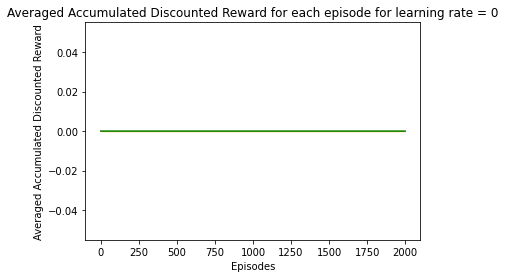

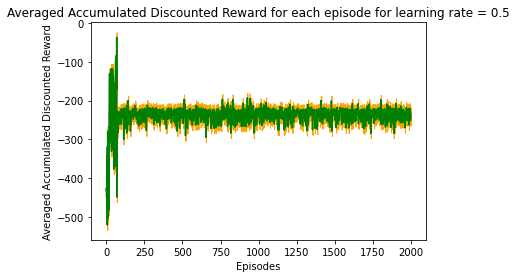

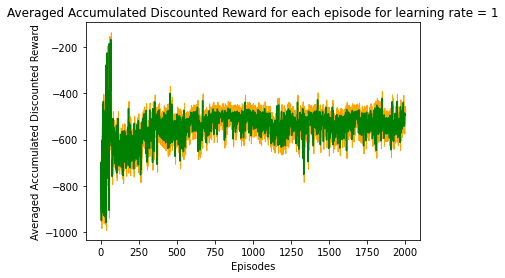

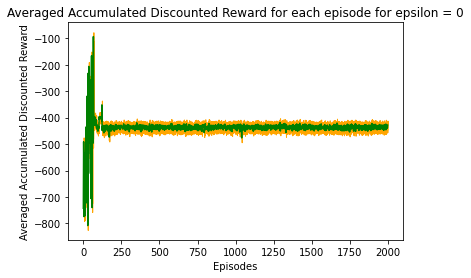

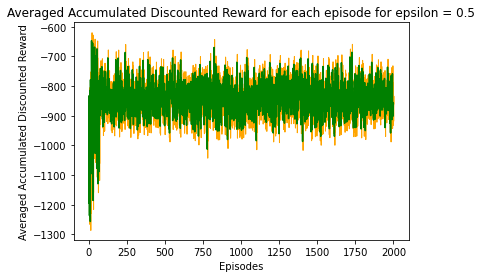

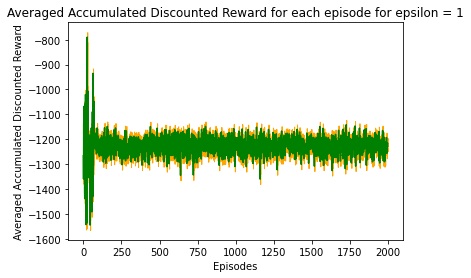

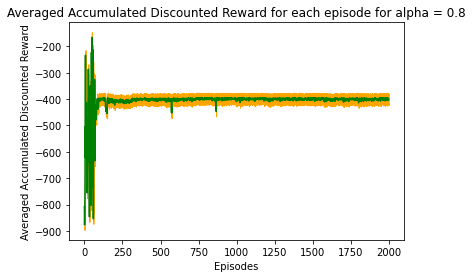

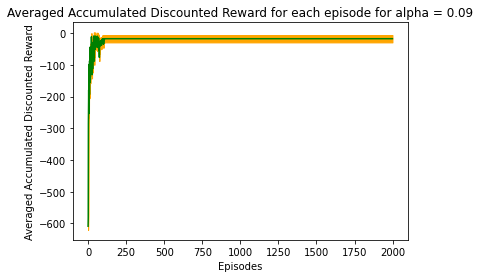

In [3]:
%run "Part1_QLearning.ipynb"

In [6]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

In [7]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cpu'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

In [8]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)#No =4 becuase actions are 4 
        
        self.act = nn.ReLU()
        self.weights=0
        
    def forward(self, x, classification = False, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        
        return out

In [9]:
def Qloss(batch, net, gamma=0.99, device="cpu"):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    #update the target (see lecture slides)
    target = rewards + gamma * next_state_values
    
    #finding loss between x and y
    return nn.MSELoss()(state_action_values, target)

In [10]:
class MazeEnvironment:    
    def __init__(self, maze, init_position, goal):
        x = len(maze)
        y = len(maze)
        
        self.boundary = np.asarray([x, y])
        self.init_position = init_position
        self.current_position = np.asarray(init_position)
        self.goal = goal
        self.maze = maze
        
        self.visited = set()
        self.visited.add(tuple(self.current_position))
                
        # initialize the empty cells and the euclidean distance from
        # the goal (removing the goal cell itself)
        self.allowed_states = np.asarray(np.where(self.maze == 0)).T.tolist()
        self.distances = np.sqrt(np.sum((np.array(self.allowed_states) -
                                         np.asarray(self.goal))**2,
                                         axis = 1))
        
        del(self.allowed_states[np.where(self.distances == 0)[0][0]])
        self.distances = np.delete(self.distances, np.where(self.distances == 0)[0][0])
                
        self.action_map = {0: [0, 1],
                           1: [0, -1],
                           2: [1, 0],
                           3: [-1, 0]}
        
        self.directions = {0: '→',
                           1: '←',
                           2: '↓ ',
                           3: '↑'}
        
        # the agent makes an action from the following:
        # 1 -> right, 2 -> left
        # 3 -> down, 4 -> up
        
    # introduce a reset policy, so that for high epsilon the initial
    # position is nearer to the goal (useful for large mazes)
    def reset_policy(self, eps, reg = 7):
        return sp.softmax(-self.distances/(reg*(1-eps**(2/reg)))**(reg/2)).squeeze()
    
    # reset the environment when the game is completed
    # with probability prand the reset is random, otherwise
    # the reset policy at the given epsilon is used
    def reset(self, epsilon, prand = 0):
        if np.random.rand() < prand:
            idx = np.random.choice(len(self.allowed_states))
        else:
            p = self.reset_policy(epsilon)
            idx = np.random.choice(len(self.allowed_states), p = p)

        self.current_position = np.asarray(self.allowed_states[idx])
        
        self.visited = set()
        self.visited.add(tuple(self.current_position))

        return self.state()
    
    
    def state_update(self, action):
        isgameon = True
        
        # each move costs -0.05
        reward = -0.05
        
        move = self.action_map[action]
        next_position = self.current_position + np.asarray(move)
        
        # if the goals has been reached, the reward is 1
        if (self.current_position == self.goal).all():
                reward = 1
                isgameon = False
                return [self.state(), reward, isgameon]
            
        # if the cell has been visited before, the reward is -0.2
        else:
            if tuple(self.current_position) in self.visited:
                reward = -0.2
        
        # if the moves goes out of the maze or to a wall, the
        # reward is -1
        if self.is_state_valid(next_position):
            self.current_position = next_position
        else:
            reward = -1
        
        self.visited.add(tuple(self.current_position))
        return [self.state(), reward, isgameon]

    # return the state to be feeded to the network
    def state(self):
        state = copy.deepcopy(self.maze)
        state[tuple(self.current_position)] = 2
        return state
        
    
    def check_boundaries(self, position):
        out = len([num for num in position if num < 0])
        out += len([num for num in (self.boundary - np.asarray(position)) if num <= 0])
        return out > 0
    
    
    def check_walls(self, position):
        return self.maze[tuple(position)] == 1
    
    
    def is_state_valid(self, next_position):
        if self.check_boundaries(next_position):
            return False
        elif self.check_walls(next_position):
            return False
        return True
    
    
    def draw(self, filename):
        plt.figure()
        im = plt.imshow(self.maze, interpolation='none', aspect='equal', cmap='Greys');
        ax = plt.gca();

        plt.xticks([], [])
        plt.yticks([], [])

        ax.plot(self.goal[1], self.goal[0],
                'bs', markersize = 4)
        ax.plot(self.current_position[1], self.current_position[0],
                'rs', markersize = 4)
        plt.savefig(filename, dpi = 300, bbox_inches = 'tight')
        plt.show()


In [11]:
def build_maze(maze_file):
        '''
        para1: filename of the maze txt file
        return mazes as a numpy array walls: 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell
        '''
        a = open(maze_file, 'r')
        m=[]
        for i in a.readlines():
            m.append(np.array(i.split(" "), dtype="int32"))
        return np.array(m)
maze=build_maze("maze_11x11.txt")

initial_position = [1,1]
goal = [len(maze)-2, len(maze)-2]

maze_env = MazeEnvironment(maze, initial_position, goal)

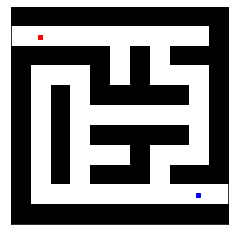

In [12]:
maze_env.draw('maze_20.png')

In [13]:
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

In [14]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])


class Agent:
    def __init__(self, maze, memory_buffer, use_softmax = True):
        self.env = maze
        self.buffer = memory_buffer # this is actually a reference
        self.num_act = 4
        self.use_softmax = use_softmax
        self.total_reward = 0
        self.min_reward = -self.env.maze.size
        self.isgameon = True

        
    def make_a_move(self, net, epsilon, device = 'cpu'):
        action = self.select_action(net, epsilon, device)
        current_state = self.env.state()
        next_state, reward, self.isgameon = self.env.state_update(action)
        self.total_reward += reward
        
        if self.total_reward < self.min_reward:
            self.isgameon = False
        if not self.isgameon:
            self.total_reward = 0
        
        transition = Transition(current_state, action,
                                next_state, reward,
                                self.isgameon)
        
        self.buffer.push(transition)
            
        
    def select_action(self, net, epsilon, device = 'cpu'):
        state = torch.Tensor(self.env.state()).to(device).view(1,-1)
        qvalues = net(state).cpu().detach().numpy().squeeze()
        #print(qvalues)

        # softmax sampling of the qvalues
        if self.use_softmax:
            p = sp.softmax(qvalues/epsilon).squeeze()
            p /= np.sum(p)
            action = np.random.choice(self.num_act, p = p)
            
        # else choose the best action with probability 1-epsilon
        # and with probability epsilon choose at random
        else:
            if np.random.rand() < epsilon:
                action = np.random.randint(self.num_act, size=1)[0] #select a random action A 
            else:          
                #Select an action that has a maximum Q value      
                action = np.argmax(qvalues, axis=0)
                action = int(action)
        
        return action
    
    
    def plot_policy_map(self, net, offset):
        net.eval()
        with torch.no_grad():
            fig, ax = plt.subplots()
            #ax.imshow(self.env.maze, 'Greys')
            q=np.zeros((len(maze), len(maze)), dtype="float64")

            for free_cell in self.env.allowed_states:
                self.env.current_position = np.asarray(free_cell)
                '''
                view is similar to numpy's reshape
                "view" shares the underlying data with the original tensor, so it is really
                a view into the old tensor instead of creating a brand new one
                '''
                #use view(1,-1) for env.state()
                qvalues = net(torch.Tensor(self.env.state()).view(1,-1)).cpu().detach().numpy().squeeze()
                #finding the argmax of qvalues
                action = np.argmax(qvalues, axis=0)
                #finding the policy from the action
                policy = self.env.directions[action]
                #updating with max qvalue 
                q[free_cell[0],free_cell[1]]=np.max(qvalues)
                

                ax.text(free_cell[1]-offset[0], free_cell[0]-offset[1], policy)
            #print(q)
            ax.imshow(q)    
            ax = plt.gca();

            plt.xticks([], [])
            plt.yticks([], [])

            #ax.plot(self.env.goal[1], self.env.goal[0], 'bs', markersize = 4)
            plt.show()
            
agent = Agent(maze = maze_env, memory_buffer = memory_buffer, use_softmax = True)

In [15]:
net = fc_nn(maze.size, maze.size, maze.size, 4)
target = fc_nn(maze.size, maze.size, maze.size, 4)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [16]:
device = 'cpu'
batch_size = 24
gamma = 0.9

net.to(device)

fc_nn(
  (fc1): Linear(in_features=121, out_features=121, bias=True)
  (fc2): Linear(in_features=121, out_features=121, bias=True)
  (fc3): Linear(in_features=121, out_features=4, bias=True)
  (act): ReLU()
)

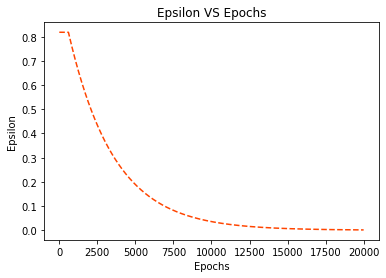

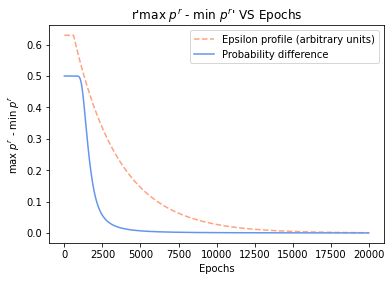

In [17]:
num_epochs = 20000

cutoff = 3000
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.title("Epsilon VS Epochs")
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
#plt.savefig('epsilon_profile.png', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.title("r'max $p^r$ - min $p^r$' VS Epochs")
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
#plt.savefig('reset_policy.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [20]:
loss_log = []
best_loss = 1e5
global estop
running_loss = 0
for epoch in range(num_epochs):
    
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent.isgameon = True
    _ = agent.env.reset(eps)

    
    while agent.isgameon:
        agent.make_a_move(net, eps)
        counter += 1
        
        if len(agent.buffer) < buffer_start_size:
            continue
            
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device = device)
        loss_t = Qloss(batch, net, gamma = gamma, device = device)
        loss_t.backward()
        optimizer.step()
        
        loss += loss_t.item()
    
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'
    
    if epoch%1000 == 0:
        agent.plot_policy_map(net, [0.35,-0.3])
    
    loss_log.append(loss)
    if epoch%5==0:
        net.weights=target.weights
    if (epoch > 2000):
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            print("inside the if statement")
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")

            estop = epoch
            print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch',estop )
    
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', epoch)
    clear_output(wait = True)
    
    for( param, target_param) in zip(net.parameters(), target.parameters()):
        target_param.data.copy_(param.data)

    if loss < best_loss:
        best_loss = loss
        torch.save(net.state_dict(), 'best_model.pth')

    if epoch%100 == 0:
        print("Epoch: {}, Loss: {:.3f}, Result: {}, Epsilon: {:.3f}".format(epoch, loss, result, eps))

Epoch 19999 (number of moves 7)
Game won
[####################################################################################################]
	 Average loss: 0.00013
	 Best average loss of the last 50 epochs: 0.00000, achieved at epoch 19999


In [21]:
torch.save(net.state_dict(), "net.torch")


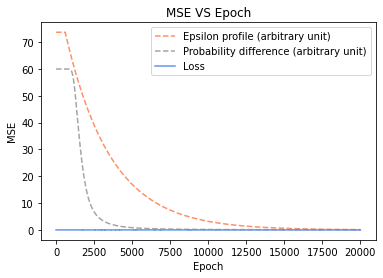

In [22]:
plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')

plt.title('MSE VS Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [23]:
torch.save(net.state_dict(), "net.torch")

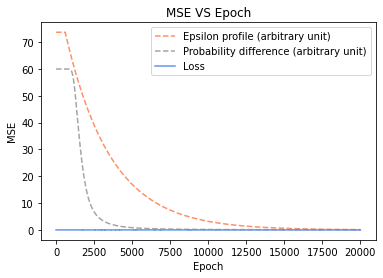

In [24]:
plt.plot(epsilon*90, alpha = 0.6, ls = '--', label = 'Epsilon profile (arbitrary unit)', color = 'orangered')
plt.plot((np.array(mpm)-np.array(mp))*120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')

plt.title('MSE VS Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

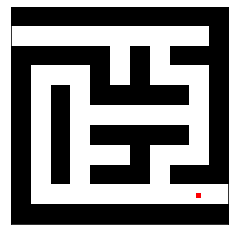

In [25]:
net.eval()
agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(net, 0)
    agent.env.draw('')
    clear_output(wait = True)

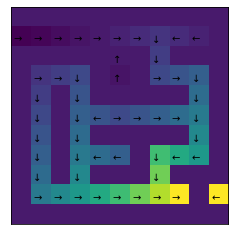

In [26]:
agent.plot_policy_map(net, [0.35,-0.3])

In [27]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load('net.torch'))

<All keys matched successfully>

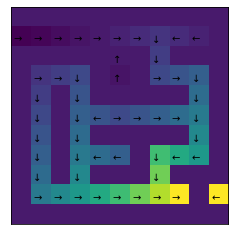

In [28]:
agent.plot_policy_map(best_net, [0.35,-0.3])

## Task 1
**Run the training with 5 different seeds and visualize the average episode reward and the variance within the error bar (with the fill_between function) similar to the Part 1 Q-Learning-final-Project**

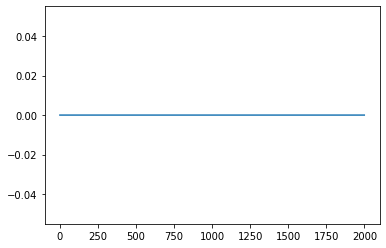

In [38]:
## Task 1
# **Run the training with 5 different seeds and visualize the average episode reward and the variance within the error bar (with the fill_between function) similar to the Part 1 Q-Learning-final-Project**
steps = 2000
numberofseeds = 5
rewards = np.zeros((numberofseeds, steps))
plt.plot(np.mean(rewards, axis = 0))
plt.fill_between(np.arange(steps), np.mean(rewards, axis = 0) - np.std(rewards, axis = 0), np.mean(rewards, axis = 0) + np.std(rewards, axis = 0), alpha = 0.3)
plt.show()


## Task 2

**Run "q_learning" and plot the accumulated reward as a function of epoch for the gamma values in (0.8, 0.2)**

Text(0.5, 0, 'Episodes')

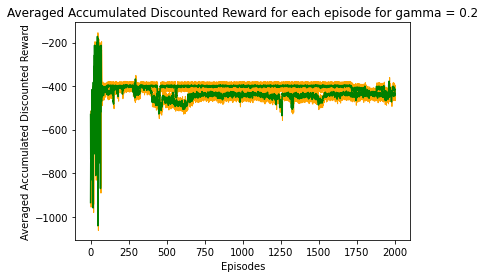

In [44]:
gamma = 0.8  

steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, 0.99, 0, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")
plt.show()

gamma = 0.2

steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.2, steps, 0.99, 0, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.2))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")
plt.show()

Text(0.5, 0, 'Episodes')

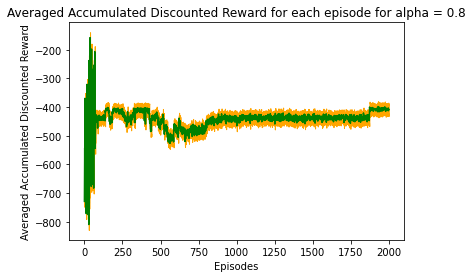

In [45]:
ALPHA = 0.8   #adding noise of 0.8

steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, 0.99, 0, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for alpha = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 3

**Run the q_learning function with adding noise to Q learning function**

Text(0.5, 0, 'Episodes')

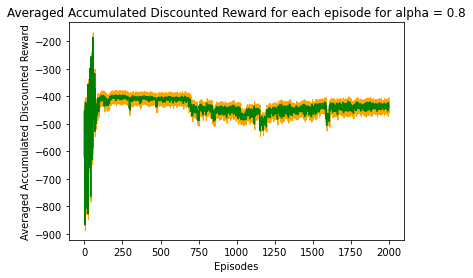

In [46]:
ALPHA = 0.8   #adding noise of 0.8

steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, 0.99, 0, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for alpha = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")


## Task 4

**Run "q_learning" and plot the accumulated reward as a function of epoch for the learning rate values in (0, 0.5, 1)**

Text(0.5, 0, 'Episodes')

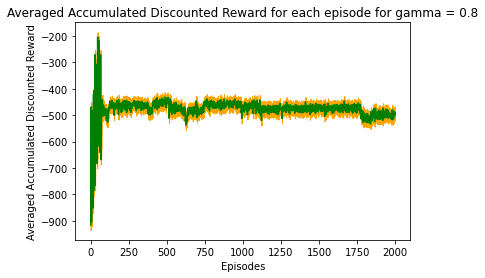

In [47]:
gamma = 0.8  
lr = 0
steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, 0.99,lr, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

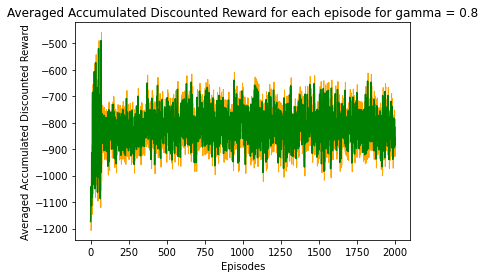

In [48]:
gamma = 0.8  
lr = 0.5
steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, 0.99,lr, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

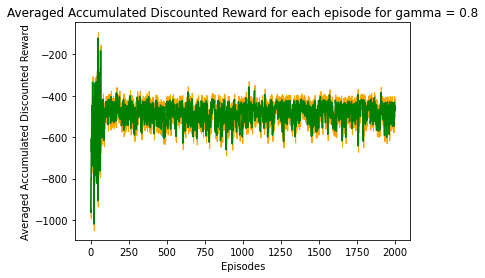

In [49]:
gamma = 0.8  
lr = 1
steps = 2000
numberOfSeeds=5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, 0.99,lr, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 5

**Run "q_learning" and plot the accumulated reward as a function of epoch for the epsilon in (0, 0.5, 1)**


Text(0.5, 0, 'Episodes')

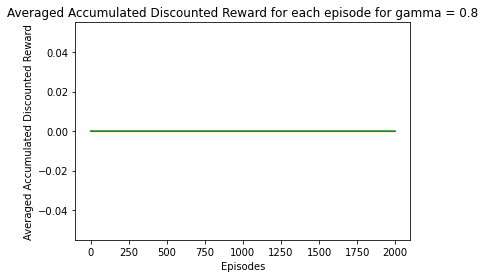

In [50]:
gamma = 0.8  
lr = 0.5
steps = 2000
numberOfSeeds=5
epsilon = 0


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, epsilon,lr, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

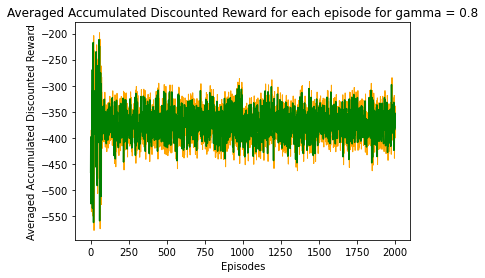

In [51]:
gamma = 0.8  
lr = 0.5
steps = 2000
numberOfSeeds=5
epsilon = 0.5


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, epsilon,lr, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

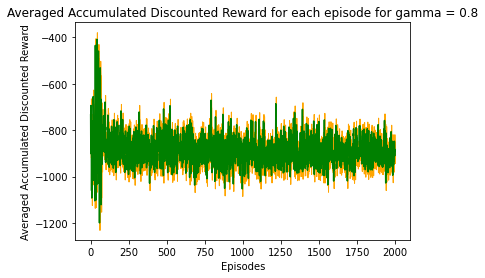

In [52]:
gamma = 0.8  
lr = 0.5
steps = 2000
numberOfSeeds=5
epsilon = 1


a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(0.8, steps, epsilon,lr, show=False)) #gamma is 0.8
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for gamma = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

## Task 6

**Run "q_learning" and plot the accumulated reward as a function of epoch for the alpha values in (0.8, 0.09)**

Text(0.5, 0, 'Episodes')

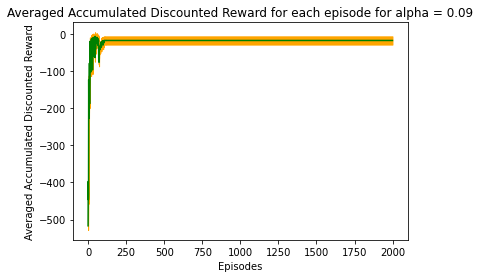

In [53]:
ALPHA = 0.09

steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.99, 0, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for alpha = " + str(0.09))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

Text(0.5, 0, 'Episodes')

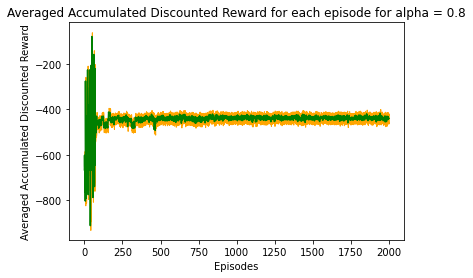

In [54]:
ALPHA = 0.8

steps = 2000
numberOfSeeds=5

# for gammas in [0.8, 0.2]:
a_rewards=[]
for i in range(numberOfSeeds):
  a_rewards.append(q_learning(gamma, steps, 0.99, 0, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)
a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode for alpha = " + str(0.8))
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")

**Observations**

- Explain briefly how the results change for different values of 'gamma'.

Explanation: For different values of gamma the results change as the gamma value is the discount factor. The discount factor is the factor by which the future rewards are discounted. The higher the gamma value the more the agent will focus on the future rewards and the lower the gamma value the more the agent will focus on the immediate rewards. 0.2 gamma gives us less rewards initially compared to 0.8 gamma. Later, as the episodes progress, they give almost the same results.


- Explain briefly how the results change for different values of 'learning rate'.

Learning rate 0 gives us no accumulated rewards. Learning rate 0.5 tends to give us more rewards in the initial episodes as compared to learning rate 1. But as the number of episodes increase, both the learning rates tend to give us more or less the same rewards. Decay in learning rate is most recommended because, we have to take giant strides towards solution initially, but as we approach the solution, we have to take smaller steps. So, adding the decay factor would help us in maneuvering the learning rate.


- Explain briefly how the results change for different values of 'alpha'.

Alpha is the noise or uncertainity in the action. Higher alpha gives us less rewards. In the program above, we can see that for alpha=0.8, the average reward stood at -400 for nearly the entire length of episodes. While lower alpha=0.09 gave us better rewards averaging at near zero.


- Explain briefly how the results change for different values of 'epsilon'.

Epsilon is the exploration-exploitation tradeoff in Q learning. It determines how the system should balance exploration and exploitation. Higher the value of epsilon, more are the chances of exploration. In the program, 0 epsilon values means that the system has no chance to explore and that it sticks to the greedy method of accumunating rewards, thus giving us minimal results. As the epsilon value grows to 0.5 and then to 1, our rewards also increase.


**Insights**

- Explain the meaning of alpha and gamma.

Alpha is the noise or uncertainity in the action. Gamma is the discounting factor that trades-off between immediate results and the results that we get in later actions. Higher gamma takes later rewards into consideration 'better' than lower gamma.



- Explain briefly the 'Exploration vs. Exploitation Trade-off'.

Exploration-Exploitation tradeoff tells the system when to explore and when to exploit. Initially when the system doesn't have much knowledge about the environment, it tends to explore. But with time, it begins to exploit using greedy method for better immediate rewards and gradually stops exploring. It is then that this trade-off helps the system to continue exploring the environment, while continuing to exploit the known states using greedy method. It is denoted using epsilon. Higher epsilon, more are the chances of exploration, and more are the chances of rewards(atleast that is what we can hope so).



- Explain briefly the diference between 'on-policy' and 'off-policy' algorithms.

On-policy algorithms means the agent follows a particular policy and tries to extract maximum rewards from the states using that policy. Off-policy means the agent goes around the environment without a fixed policy, explores on its own and behave randomly, while still arriving at optimal policy on its own.


- Explain briefly the meaining of 'Experience Replay'.

In Deep Q-networks, we store the agent's experiences at each time step in a data set called the replay memory and this process is called Experience Replay. Main reason for using the replay memory is to break the correlation between consecutive samples. We take random samples from the replay memory to break this correlation and in turn avoid inefficient learning.


- Explain briefly the purpose of a target network in DQN algorithm.

A target network in DN algorithm calculates the target value and is updated by the Q function at regular intervals. This is used to stabilise the learning process. A less frequent updates of the target network would result in a more stable learning process.

- Explain briefly the difference between epochs and episode.

An epoch is a complete pass through the training dataset by the agent. An episode is a single instance of interaction between the agent and the environment.

